In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from cuml.cluster import KMeans as cuKMeans
from cuml.neighbors import NearestNeighbors
import cupy

In [4]:
from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd
from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN

In [5]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
client = Client(cluster)

In [6]:
!python --version

Python 3.7.10


In [14]:
!pwd

/rapids/notebooks/host/transformer_attention_clustering/clustering


In [8]:
output_dir='/rapids/notebooks/host/representations/output/'

In [16]:
import glob

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)


In [17]:
# load full partitioned dataset - read in as pandas df,
# for some reason dask cuml dbscan doesn't accept a dask cdDF?
# https://docs.rapids.ai/api/cuml/nightly/api.html?highlight=regression#multi-node-multi-gpu-algorithms
gdf = pd_read_pattern('/rapids/notebooks/host/representations/final/partitions/*.csv')

In [ ]:
%%time
cuml_dbscan = daskDBSCAN( eps = 0.75,
                          metric='euclidean',
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(gdf)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

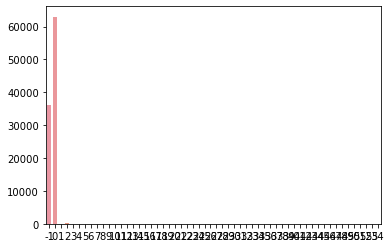

In [44]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [45]:
rating_count

 0     62977
-1     36019
 2       352
 11       50
 5        35
 1        22
 3        22
 35       21
 18       19
 23       16
 20       16
 21       15
 22       14
 19       14
 24       13
 39       12
 41       12
 33       12
 38       12
 42       12
 10       12
 4        12
 27       11
 44       11
 25       11
 28       11
 26       10
 37       10
 54       10
 51       10
 50       10
 49       10
 47       10
 45       10
 43       10
 17       10
 12       10
 8        10
 36       10
 15       10
 13       10
 30       10
 34       10
 31       10
 9         9
 32        9
 40        9
 14        8
 7         8
 29        8
 6         7
 16        7
 46        6
 48        6
 52        6
 53        4
Name: 0, dtype: int64

In [7]:
med = df[:400000]

In [8]:
med = med.iloc[:,1:]

In [9]:
%%time
cuml_dbscan = cumlDBSCAN( eps = 0.75,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(med)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



--- 4578.115650892258 seconds ---
Estimated number of clusters: 69
Estimated number of noise points: 105521
CPU times: user 1h 16min 21s, sys: 2.47 s, total: 1h 16min 23s
Wall time: 1h 16min 18s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

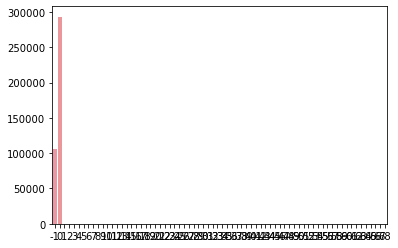

In [13]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
label_count = df_labels[0].value_counts()

x = label_count.index
y = label_count.values

sns.barplot(x, y)

In [14]:
rating_count

 0     293241
-1     105521
 2        198
 4         46
 10        42
        ...  
 67         8
 9          7
 56         7
 43         7
 57         5
Name: 0, Length: 70, dtype: int64

In [15]:
rating_count[:20]

 0     293241
-1     105521
 2        198
 4         46
 10        42
 1         40
 6         40
 60        37
 26        33
 25        33
 51        30
 15        30
 5         28
 14        26
 46        24
 7         23
 13        21
 45        21
 8         19
 53        19
Name: 0, dtype: int64